# Classifying handwritten digits (0-9) with neural networks 

<h1>Getting Set Up</h1>

Random is the default python library for generating random numbers.

PyTorch, or torch, is the python deep learning library we use for our neural networks. 

Torchvision is for computer vision specific functions such as transforming images and image datasets. 

Matplotlib is used for graphing figures with data, whether it be scatterplots, heatmaps, lineplots, etc...

In [14]:
import random
import torch
import torchvision
import matplotlib.pyplot as plt

<h1>Preprocessing our Images</h1>

The transform that we will perform on our dataset is first converting all images to tensors. Tensors are the built in array datatype in pytorch, like numpy arrays. If interested, learn about why they are useful in keeping track of gradients here:
https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html .

Converting to a tensor also converts an image with pixel values from 0 to 255 to a matrix with numbers from 0 to 1. 

In addition, we are normalizing the data to a range between \-1 and 1. If  
the range before is \[0,1\], subtracting 0.5 will give us \[\-0.5,0.5\] and dividing by 0.5 will make the range wider to \[\-1,1\]. torch.Normalize subtracts the first parameter from all the values in the image and divides by the second parameter.   



In [15]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.5,), (0.5,)),
])

# Applying the transforms

We are using the datasets.MNIST function from torchvision to import the dataset. 

Parameters to the function:

The root parameter sets the directory that we import the data to (and create it if it doesn't exist.)

The train parameter determines if we are importing training or testing fashion MNIST dataset. 

The transform parameter determines the transforms we apply during preprocessing, which were defined above.

download=True gives the function permission to download the data into the directory if it doesn't exist there. 

In [16]:
trainset = torchvision.datasets.MNIST('train_set', download=True, train=True, transform=transform) # downloads to train_set
valset = torchvision.datasets.MNIST('test_set', download=True, train=False, transform=transform) # downloads to test_set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # batch is the number of images to consider at a time
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

## Visualization !!!

For 10 iterations, select a random index from zero to the length of the training dataset. Display each image in a 2 by 5 subplot as the 1st, 2nd, 3rd etc... image in the plot.

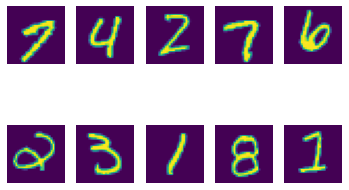

In [17]:
for i in range(10):
    rand_idx = random.randint(0, len(trainset)-1) # Pick an index for a random image
    plt.subplot(2, 5, i+1) # 2 * 5 images in the grid, display 10 total
    plt.axis('off')
    # [1, 28, 28] -> [28, 28]
    plt.imshow(trainset[rand_idx][0].squeeze(0))

<h1>Creating the Model</h1>

## Hyperparameters

datasets docs - https://pytorch.org/vision/stable/datasets.html

The input size is the pixel size of the images, each of which is 28 by 28.

The number of classifcation (num_classes) is 10 because there are 10 possible classifications the model can make, such as 0, 1, 2 ... 9. 

The hidden_sizes is the number of neurons in the hidden layer of the neural network. The input size and output sizes are always fixed (input size is related to number of pixels and output size is the number of classes) but the optimal hidden layer sizes can be determined only through experimentation. 


In [18]:
input_size = 28 * 28 # width times height of the image (number of pixels)
hidden_sizes = [128, 32] # this is the sizes of the hidden layers. The sizes are relativly arbitrary
num_class = 10 # one label for each digit (0-9)

GPU boost training time. Why? Because it lets us do many operations at the same time in a parallelized sort of way. 

CUDA is the API that we will use for GPU training. If CUDA is available we want to use it, and otherwise use the CPU. Google colab comes with a built in GPU for use so make sure to activate it by going to Runtime->Change runtime type->GPU

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Build a neural network in pytorch with two hidden layers

So torch.nn.Sequential pretty much compiles a group of layers into one network, and runs them sequentially for predictions. All of the layers that we are using for this are fully connected layers. The input size is 28 by 28 because we are flattening out the 28 by 28 image into 28*28=784 numbers. We are adding a activation function ReLU after that. ReLU(x) = max(x,0) so relu turns negative values to zero and positive values stay the same. 

After the first layer, we take the number of outputs of the first layer as the number of inputs into the second layer. And an arbitrary number of outputs for the second layer that we decide. 

Notice how we have an activation function after each layer. 

Then the third layer you code yourself, view the instructions below. 

Finally, we have an output activation function. The 10 numbers that are outputted from our previous layer can be any numbers from negative infinity to infinity. We want every class output to be from zero to one, like a probability. The softmax activation function turns the output into a probability for each class. 

In [20]:
model = torch.nn.Sequential(
    # [(64) batch_size, (768) width x height] -> [(64) batch_size, (128) hidden_size #1]
    torch.nn.Linear(input_size, hidden_sizes[0]),
    torch.nn.ReLU(), # activation function
    # [(64) batch_size, (128) hidden_size #1] -> [(64) batch_size, (32) hidden_size #2]
    torch.nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    torch.nn.ReLU(), # activation function
    # [(64) batch_size, (32) hidden_size #2] -> [(64) batch_size, (10) num_class]

    #EXERCISE: Define the third layer as taking in the output size of the second layer and outputting the number of classes. 
    torch.nn.Linear(hidden_sizes[1], num_class),
    # output activation function - the hidden layer functions don't work for optimization
    # LogSoftmax because it is better at gradient optimization
    torch.nn.LogSoftmax(dim=-1) # apply LogSoftmax to the last layer (num_class)
)

We have to transfer the model to the GPU device. 

In [21]:
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=10, bias=True)
  (5): LogSoftmax(dim=-1)
)

<h1>Training the model</h1>

## Training our Model

The training process goes somewhat like this
go through the dataset [epoch] times<br>
&ensp;  go through each image in the dataset<br>
&ensp;&ensp; transfer inputs and labels to GPU<br>
&ensp;&ensp; get prediction for input<br>
&ensp;&ensp; check if prediction matches label, get loss<br>
&ensp;&ensp; see which direction you have to change the weights<br>
&ensp;&ensp; actually change weights using optimizer and learning rate
&ensp;&ensp; Set the directions back to zero (optim.zero_grad())<br>
&ensp;&ensp; add loss to total loss until reset<br>
&ensp;&ensp; after some iterations, print out loss and reset

Few more things to note. NLLLoss is the default loss function for softmax (probabilities that are far away from the true probabilities are penalized). 

NLLLoss docs \- [https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html?highlight=nllloss  
\#torch.nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html?highlight=nllloss#torch.nn.NLLLoss)
Optim docs \- https://pytorch.org/docs/stable/optim.html



In [22]:
# Model training for 8 times
criterion = torch.nn.NLLLoss() # Loss object to find back propagation
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9) # Optimizer
epochs = 8
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #EXERCISE: transfer images and labels to GPU. 
        model.to(device)
        # Formats the image to be a usable 1d array.
        #   [(64) batch size, 1, 28, 28] -> [(64) batch size, 768]
        images = images.view(images.shape[0], -1)
    
        # Resets the optimizer for each training step
        optimizer.zero_grad()
        
        # Finds error then runs back propagation
        output = model(images)
        #EXERCISE: calculate the loss by passing the outputs and the labels into the loss function. 
        loss = criterion(output, labels)
        loss.backward()
        
        # Updates model weights
        optimizer.step()
        
        # Keeps track of error to allow visualization of progress
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

Epoch 0 - Training loss: 0.6972125582952997


Epoch 1 - Training loss: 0.2940487665082537


Epoch 2 - Training loss: 0.23107895712211315


Epoch 3 - Training loss: 0.18696057816733047


Epoch 4 - Training loss: 0.15818828055218084


Epoch 5 - Training loss: 0.1363015104728594


Epoch 6 - Training loss: 0.1190829524762436


Epoch 7 - Training loss: 0.10665151549439662


## Evaluation Loop
&ensp; Iterate through every batch in the dataset<br>
&ensp;&ensp; Get the prediction of every image in the batch<br>
&ensp;&ensp; Add the number of images to the total<br>
&ensp;&ensp; Add the number of correctly classified images to a counter<br>
&ensp;&ensp; Get the accuracy through correct/total.<br>


In [23]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images, labels in valloader:
        #EXERCISE: Transfer the inputs and labels to the GPU
        model.to(device)
        #EXERCISE: calculate outputs by running images through the network
        
        images = images.view(images.shape[0], -1)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 96 %


In [34]:
valset[2][1]

1

<h1>Using the Model!</h1>

Got your own image to run prediction on?

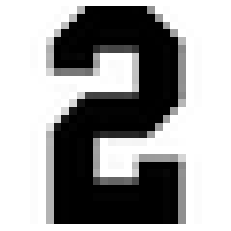

In [60]:
# get and show a sample image
#image = valset[10][0] # shape: [(1) batch_size, 28, 28]
image = mpimg.imread('Number 2 PNG images free download_PNG14946.png')
plt.subplot()
plt.axis('off')
# [1, 28, 28] -> [28, 28] - makes the image readable
plt.imshow(image)

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
 
# Read Images
#img = mpimg.imread('Number 2 PNG images free download_PNG14946.png')
 
# Output Images
#plt.imshow(img)

Run Prediction

In [61]:
# [(1) batch_size, 28, 28]-> [1(batch size), 784]
image = image.view(1, 784)
with torch.no_grad():
    # cast input to device
    image = image.to(device)

    log_preds = model(image) # runs the model

# post processes the image into probabilities of it being each digit
#   Math: probabilites were natural logged, so torch.exp() performs e^(log_preds)
preds = torch.exp(log_preds)
probab = list(preds.cpu().numpy()[0])

# the index, this time, is the same as the output, so we can just grab and print it
pred_label = probab.index(max(probab)) # get index of highest num (highest probability)
print(f"Prediction: {pred_label}")

ValueError: Type must be a sub-type of ndarray type